<a href="https://colab.research.google.com/github/Seong-jieun/Toy_Project/blob/main/Shop_customer_segment/Shop_customer_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

- 고객의 성별, 연령, 연간 소득, 직업, 가족 수 등의 정보가 있는 가상의 고객 데이터이다
    - 출처: https://www.kaggle.com/datasets/datascientistanna/customers-dataset/data
- 진행 작업
    - EDA, 고객세분화
    - 피처엔지니어링, 클러스터링

# 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/personal_da_project/Customers.csv')

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


# 데이터 전처리

In [ ]:
# 데이터 크기 확인
df.shape

(2000, 8)

In [ ]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [ ]:
# 결측값 수 확인
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income ($),0
Spending Score (1-100),0
Profession,35
Work Experience,0
Family Size,0


In [ ]:
# 'Profession' 컬럼의 결측치 처리 -> 최빈값으로 채우기
df['Profession'].fillna(df['Profession'].mode()[0], inplace=True)

In [ ]:
# 컬럼명 수정 1. 괄호삭제
df.rename(columns={'Annual Income ($)':'Annual Income'}, inplace=True)
df.rename(columns={'Spending Score (1-100)':'Spending Score'}, inplace=True)

# 컬럼명 수정 2. 공백을 '_'로 변경
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
# 컬럼 분포 확인
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,2000.0,NaN,NaN,NaN,1000.5,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Gender,2000,2,Female,1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2000.0,NaN,NaN,NaN,48.96,28.429747,0.0,25.0,48.0,73.0,99.0
Annual_Income,2000.0,NaN,NaN,NaN,110731.8215,45739.536688,0.0,74572.0,110045.0,149092.75,189974.0
Spending_Score,2000.0,NaN,NaN,NaN,50.9625,27.934661,0.0,28.0,50.0,75.0,100.0
Profession,2000,9,Artist,647,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,2000.0,NaN,NaN,NaN,4.1025,3.922204,0.0,1.0,3.0,7.0,17.0
Family_Size,2000.0,NaN,NaN,NaN,3.7685,1.970749,1.0,2.0,4.0,5.0,9.0


In [ ]:
# 나이가 15세 미만인데도 직업이 할당되어있는데 현실성이 떨어진다고 판단하여 15세 이상인 데이터만 남기는 것으로 한다
df = df[df['Age'] >= 15]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1726 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CustomerID       1726 non-null   int64 
 1   Gender           1726 non-null   object
 2   Age              1726 non-null   int64 
 3   Annual_Income    1726 non-null   int64 
 4   Spending_Score   1726 non-null   int64 
 5   Profession       1726 non-null   object
 6   Work_Experience  1726 non-null   int64 
 7   Family_Size      1726 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 121.4+ KB


**<최종 컬럼 정보>**

|컬럼명|설명|
|---|---|
|CustomerID|고객 고유 ID, 고유 식별자 역할|
|Gender|고객의 성별|
|Age|고객의 연령|
|Annual_Income|고객의 연간 소득, 단위는 달러(\$)|
|Spending_Score|매장에서 매긴 고객의 소비 점수(1점 ~ 100점)|
|Profession|고객의 직업|
|Work_Experience|고객의 근무 연수|
|Family_Size|고객의 가족 수|

In [ ]:
# 최종 컬럼별 분포 확인
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,1726.0,NaN,NaN,NaN,984.187138,583.903558,1.0,477.25,988.5,1484.75,2000.0
Gender,1726,2,Female,1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1726.0,NaN,NaN,NaN,55.650637,24.624818,15.0,34.0,55.0,78.0,99.0
Annual_Income,1726.0,NaN,NaN,NaN,109380.236385,46191.517892,0.0,73759.25,107211.0,148542.75,189974.0
Spending_Score,1726.0,NaN,NaN,NaN,50.562572,27.85258,0.0,27.25,50.0,75.0,100.0
Profession,1726,9,Artist,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,1726.0,NaN,NaN,NaN,4.052723,3.896055,0.0,1.0,3.0,7.0,17.0
Family_Size,1726.0,NaN,NaN,NaN,3.776941,1.958574,1.0,2.0,4.0,5.0,9.0


# EDA

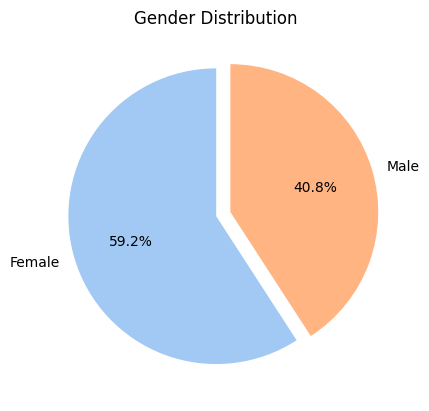

In [ ]:
# 성별 분포 - 비율 확인
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].value_counts().index
        , autopct='%1.1f%%', startangle=90, explode=[0, 0.1], colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.show()

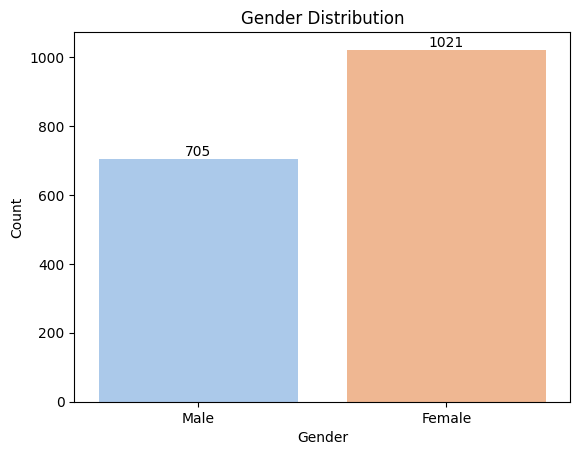

In [ ]:
# 성별 분포 - 카운트 확인
sns.countplot(data=df, x='Gender', palette='pastel')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

- 여성은 1021명(59.2%), 남성은 705명(40.8%)이다

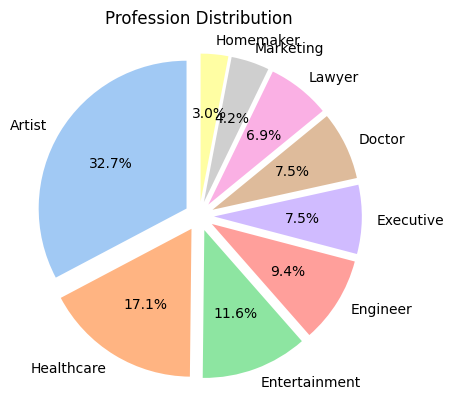

In [ ]:
# 직업 분포 - 비율 확인
plt.pie(df['Profession'].value_counts(), labels=df['Profession'].value_counts().index,
        autopct='%1.1f%%', startangle=90, explode=[0.1] * len(df['Profession'].value_counts())
        , colors=sns.color_palette('pastel'))
plt.title('Profession Distribution')
plt.show()

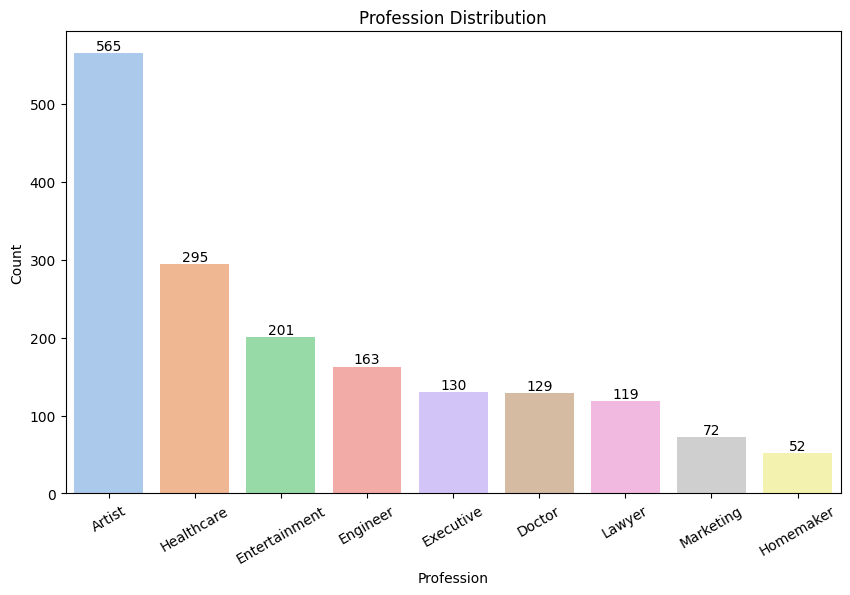

In [ ]:
# 직업 분포 - 카운트 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Profession', order=df['Profession'].value_counts().index, palette='pastel')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), int(p.get_height()), ha='center', va='bottom')

plt.title('Profession Distribution')
plt.xlabel('Profession')
plt.xticks(rotation=30)
plt.ylabel('Count')
plt.show()

- Artist(32.7%)가 많은 비율을 차지하는 것으로 나타났는데 결측값을 최빈값으로 대체한 영향도 있을 것으로 추측된다
- Artist(565명) 다음으로는 Healthcare(295명), Entertainment(201명), Engineer(163명)순으로 많았다
- Homemaker가 52명으로 제일 적었다

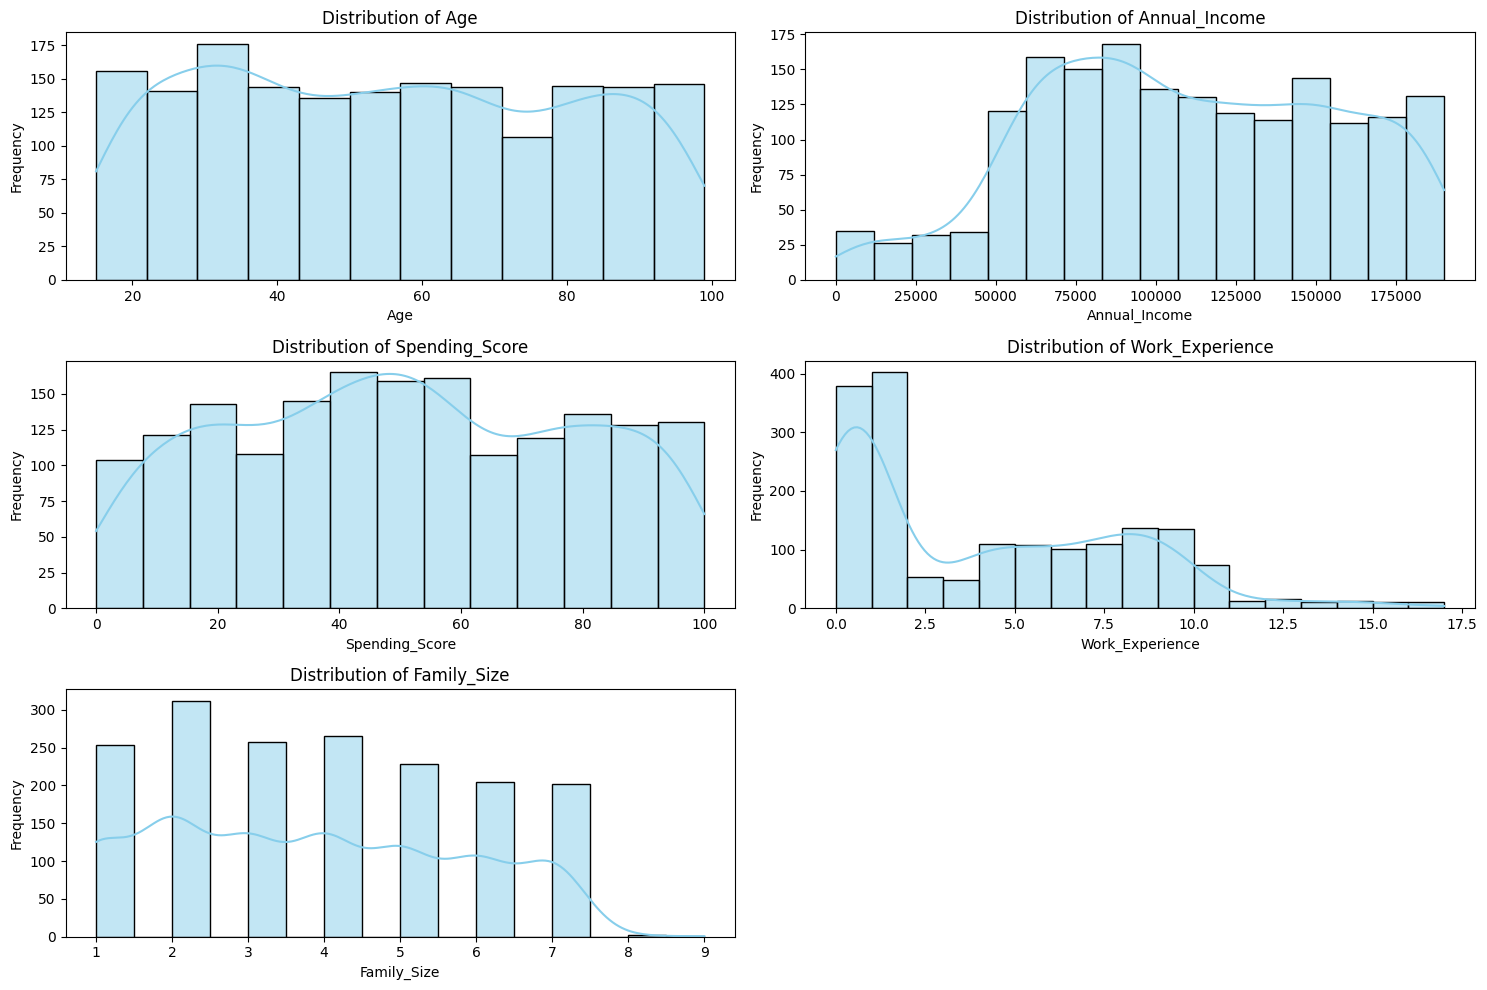

In [ ]:
# 연속형 변수 시각화
numerical_cols = ['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=col, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

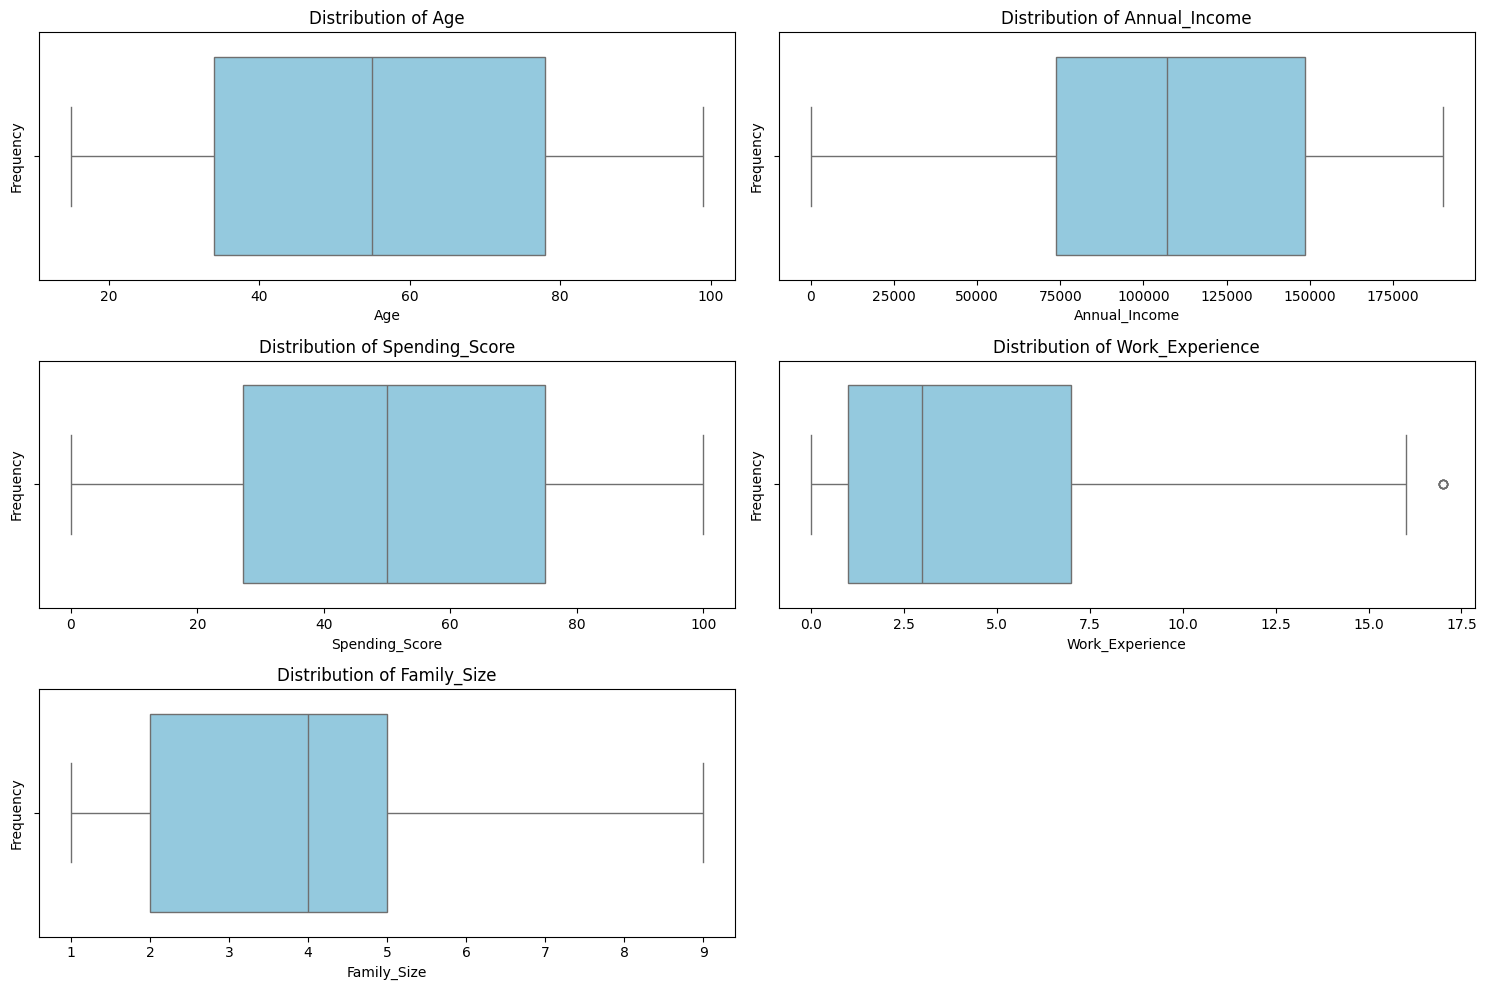

In [ ]:
# 박스플롯으로 이상치 확인
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 피처엔지니어링

In [ ]:
# 범주형 변수 인코딩
le = LabelEncoder()

df_scaled = df.copy()

categorical_cols = ['Gender', 'Profession']
for col in categorical_cols:
    df_scaled[col] = le.fit_transform(df_scaled[col])

In [ ]:
# # 연속형 변수 중 무한 값을 NaN값으로 대체
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # NaN값을 중앙 값으로 대체 -> 이상치의 영향을 덜 받기 위함
# for col in df.select_dtypes(include=np.number).columns: # 숫자형 컬럼만 선택
#     df[col].fillna(df[col].median(), inplace=True)

# 연속형 변수 스케일링
scaler = StandardScaler()

numerical_cols = ['Age', 'Annual_Income', 'Spending_Score', 'Work_Experience', 'Family_Size']
for col in numerical_cols:
    df_scaled[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_scaled[col].fillna(df_scaled[col].median(), inplace=True)
    df_scaled[col] = scaler.fit_transform(df_scaled[[col]])

In [ ]:
df_scaled.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size
0,1,1,-1.488793,-2.043830,-0.415255,5,-0.783769,0.113922
1,2,1,-1.407551,-1.610724,1.093121,2,-0.270281,-0.396802
2,3,0,-1.448172,-0.506305,-1.600408,2,-0.783769,-1.418249
3,4,0,-1.326308,-1.090998,0.949466,7,-1.040513,-0.907525
4,5,0,-1.001339,-1.545758,-0.379341,3,-0.527025,1.135368


# 상관관계 확인

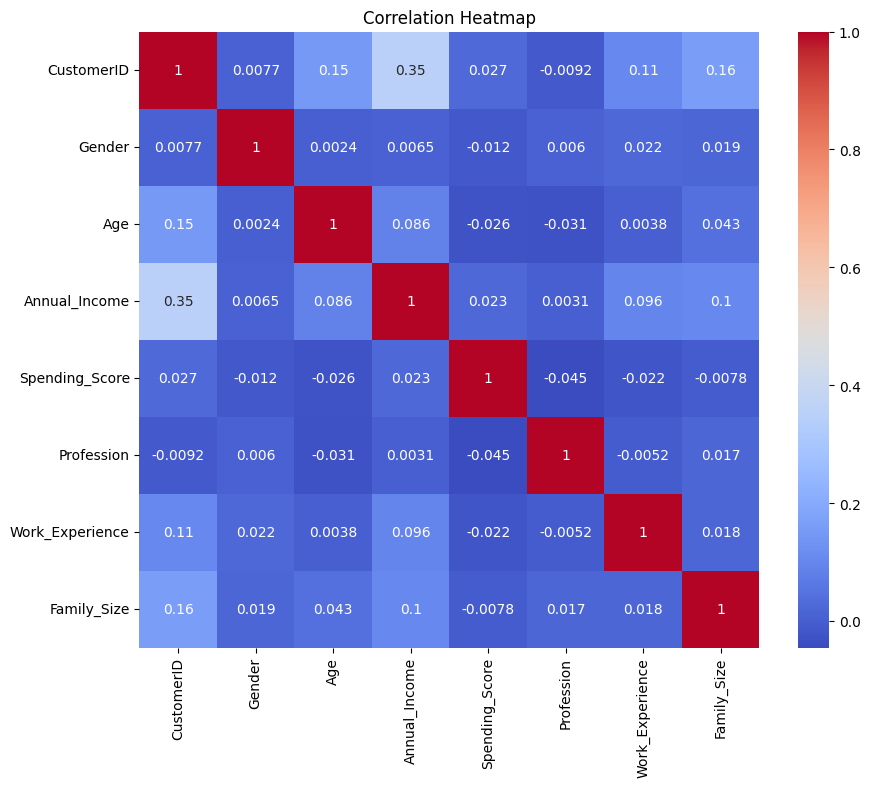

In [ ]:
# 상관관계 확인
corr = df_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- 상관관계 확인 결과, 각 변수 간 눈에 띄는 상관관계가 없는 것으로 보인다


# PCA(주성분 분석)를 통한 차원 축소

- 해당 데이터 셋은 다차원(컬럼 8개) 데이터 셋이므로 클러스터링 성능을 향상  시키기위해 PCA를 통한 차원 축소를 진행한다

In [ ]:
# 3차원으로 축소
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)

# K-Means 클러스터링

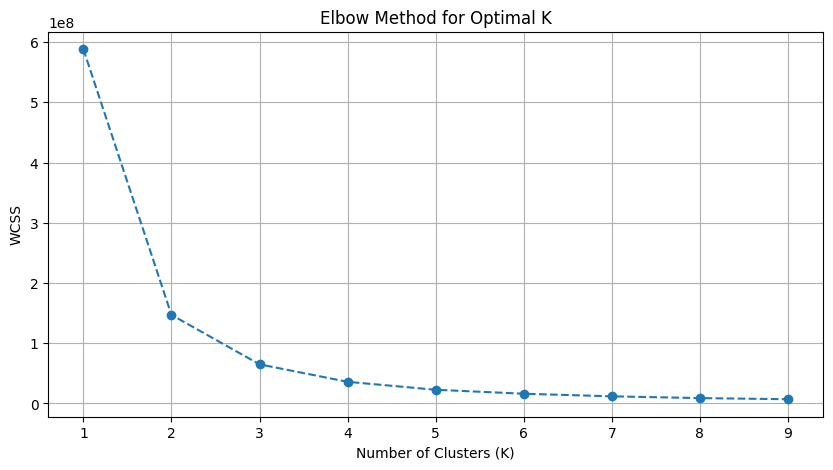

In [ ]:
# 엘보우 메소드로 최적의 k 찾기
wcss = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)  # inertia_는 WCSS 값

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

In [ ]:
# K-means 클러스터링을 적용할 데이터프레임 생성
df_kmeans = df_scaled.copy()

# 모델 학습 및 예측
kmeans = KMeans(n_clusters=3, random_state=42)          # 최적의 k는 3
df_kmeans['Cluster'] = kmeans.fit_predict(pca_result)

# 결과 확인
df_kmeans.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score,Profession,Work_Experience,Family_Size,Cluster
0,1,1,-1.488793,-2.043830,-0.415255,5,-0.783769,0.113922,2
1,2,1,-1.407551,-1.610724,1.093121,2,-0.270281,-0.396802,2
2,3,0,-1.448172,-0.506305,-1.600408,2,-0.783769,-1.418249,2
3,4,0,-1.326308,-1.090998,0.949466,7,-1.040513,-0.907525,2
4,5,0,-1.001339,-1.545758,-0.379341,3,-0.527025,1.135368,2


In [ ]:
# 클러스터별 명칭 수정
df_kmeans['Cluster'] = df_kmeans['Cluster'].map({0: 'A', 1: 'B', 2: 'C'})

# KMeans Cluster 기준으로 분포 확인
df_kmeans.groupby('Cluster').describe()

CustomerID                                                             \
             count         mean         std     min      25%     50%      75%   
Cluster                                                                         
A            574.0   995.156794  193.936424   656.0   826.75   998.5  1161.50   
B            566.0  1664.367491  195.497159  1329.0  1492.25  1664.0  1836.75   
C            586.0   316.476109  193.018303     1.0   147.25   305.5   486.75   

                Gender            ... Work_Experience           Family_Size  \
            max  count      mean  ...             75%       max       count   
Cluster                           ...                                         
A        1328.0  574.0  0.405923  ...        0.499952  2.553906       574.0   
B        2000.0  566.0  0.416961  ...        1.013441  2.553906       566.0   
C         654.0  586.0  0.402730  ...        0.756696  3.324139       586.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
Cluster                                                                        
A        0.137055  0.994536 -1.418249 -0.907525  0.113922  1.135368  1.646092  
B        0.103996  1.030623 -1.418249 -0.907525  0.113922  1.135368  1.646092  
C       -0.234695  0.933635 -1.418249 -0.907525 -0.396802  0.624645  2.667539  

[3 rows x 64 columns]

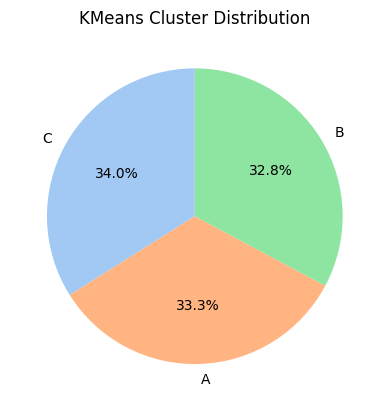

In [ ]:
# 클러스터별 구성 비율 시각화
plt.pie(df_kmeans['Cluster'].value_counts(), labels=df_kmeans['Cluster'].value_counts().index
        , autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('KMeans Cluster Distribution')
plt.show()

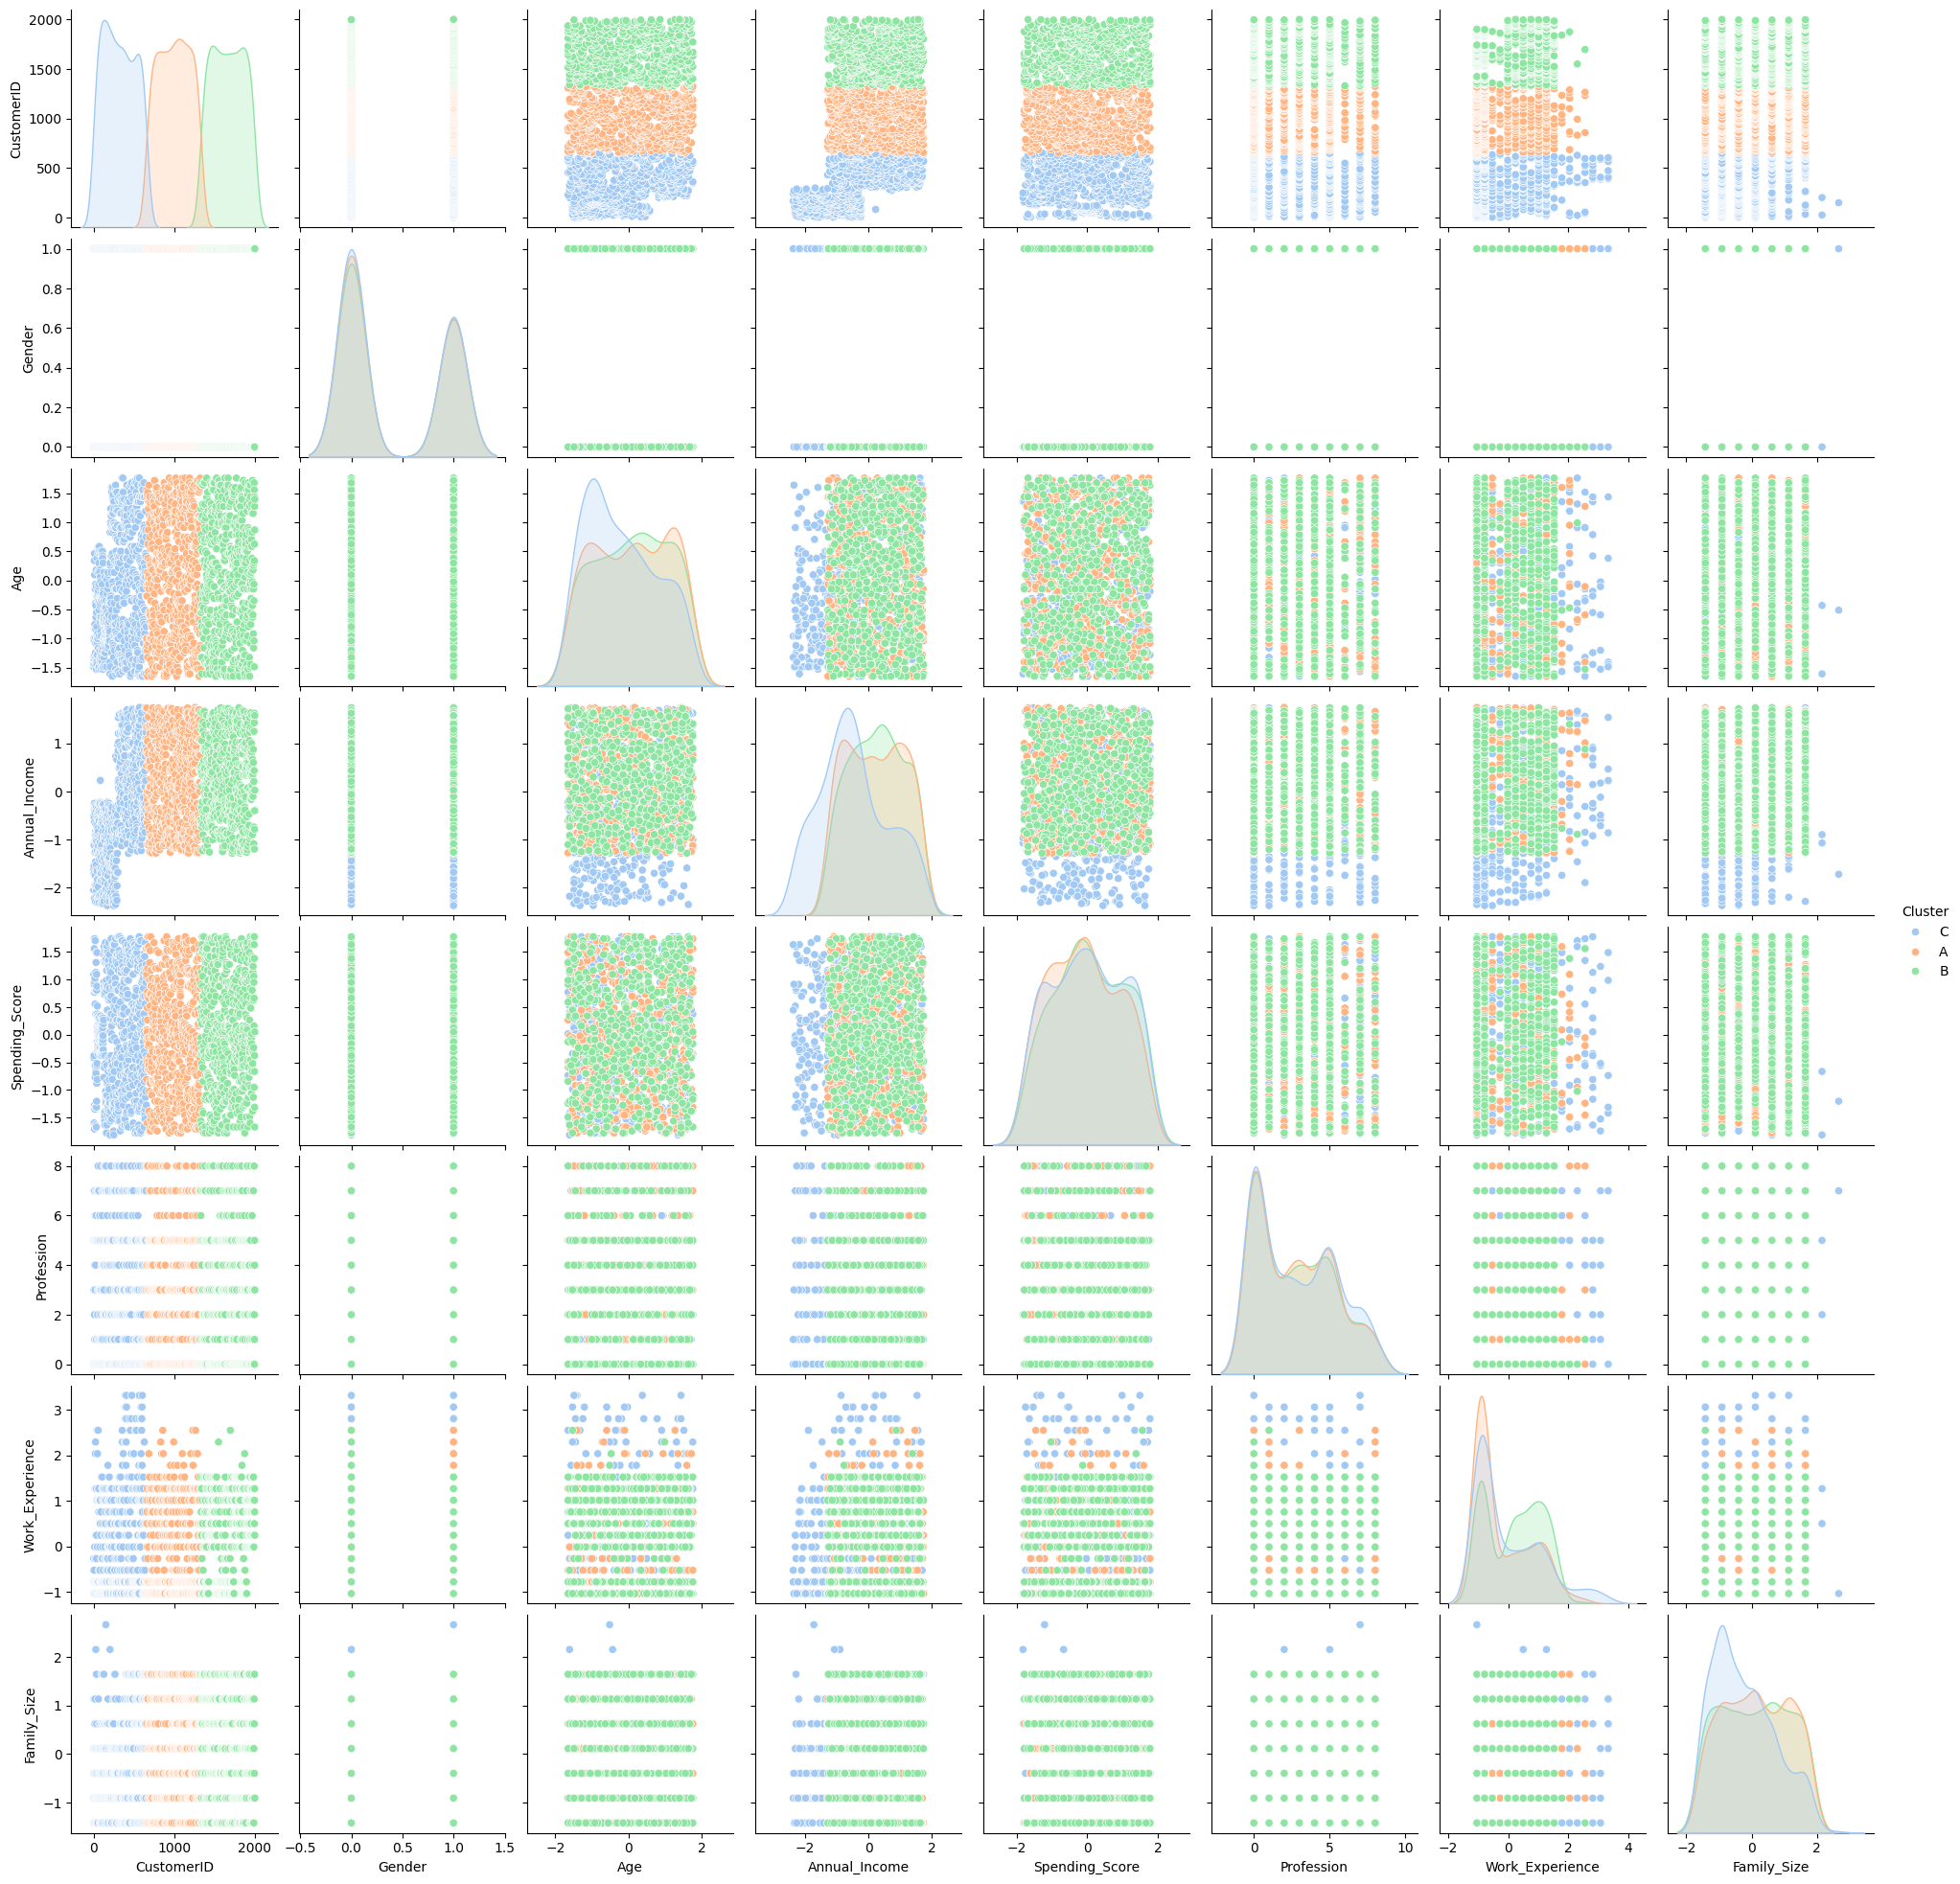

In [ ]:
# 컬럼 간 관계 시각화
plt.axes = sns.pairplot(df_kmeans, hue='Cluster', palette='pastel')
plt.show()

In [ ]:
silhouette_kmeans = silhouette_score(pca_result, df_kmeans['Cluster'])
print(f'KMeans 클러스터링 결과 silhouette Score: {silhouette_kmeans:.2f}')

KMeans 클러스터링 결과 silhouette Score: 0.59


[K-Means 클러스터링 결과]

- 3개로 군집이 형성되었고 각 군집의 구성비율은 33% 내외로 고르게 분포한다
- 실루엣 계수는 0.59이다
    - 실루엣 계수는 값이 1에 가까울수록 군집화가 잘 이루어졌으며 0.5~0.7일 경우 양호한 군집화로 군집이 비교적 잘 분리되었고, 각 군집 내 데이터의 응집도가 높다고 평가한다

# 고객 세분화

In [ ]:
# 클러스터 레이블을 원본데이터(df)에 추가
df['Cluster'] = df_kmeans['Cluster']

In [ ]:
# 클러스터별 분포 확인
df.groupby('Cluster').describe().T

Cluster                            A              B              C
CustomerID      count     574.000000     566.000000     586.000000
                mean      995.156794    1664.367491     316.476109
                std       193.936424     195.497159     193.018303
                min       656.000000    1329.000000       1.000000
                25%       826.750000    1492.250000     147.250000
                50%       998.500000    1664.000000     305.500000
                75%      1161.500000    1836.750000     486.750000
                max      1328.000000    2000.000000     654.000000
Age             count     574.000000     566.000000     586.000000
                mean       57.958188      58.084806      51.039249
                std        25.063514      24.590664      23.589585
                min        15.000000      15.000000      15.000000
                25%        35.250000      37.250000      32.000000
                50%        59.000000      59.000000      48.000000
                75%        81.000000      79.000000      68.750000
                max        99.000000      99.000000      99.000000
Annual_Income   count     574.000000     566.000000     586.000000
                mean   119233.905923  121486.206714   88035.551195
                std     41323.835704   39099.166330   49487.393241
                min     50250.000000   50223.000000       0.000000
                25%     81748.250000   89774.000000   52803.500000
                50%    118116.000000  123155.000000   83779.500000
                75%    155812.250000  152318.000000  121189.500000
                max    189945.000000  189689.000000  189974.000000
Spending_Score  count     574.000000     566.000000     586.000000
                mean       48.454704      52.404594      50.848123
                std        27.390025      27.686051      28.366451
                min         1.000000       1.000000       0.000000
                25%        25.000000      31.000000      28.000000
                50%        48.000000      51.000000      51.000000
                75%        71.000000      76.000000      75.000000
                max       100.000000     100.000000     100.000000
Work_Experience count     574.000000     566.000000     586.000000
                mean        3.303136       4.830389       4.035836
                std         3.628291       3.525813       4.326868
                min         0.000000       0.000000       0.000000
                25%         0.000000       1.000000       1.000000
                50%         1.000000       5.000000       2.000000
                75%         6.000000       8.000000       7.000000
                max        14.000000      14.000000      17.000000
Family_Size     count     574.000000     566.000000     586.000000
                mean        4.045296       3.980565       3.317406
                std         1.947309       2.017966       1.828064
                min         1.000000       1.000000       1.000000
                25%         2.000000       2.000000       2.000000
                50%         4.000000       4.000000       3.000000
                75%         6.000000       6.000000       5.000000
                max         7.000000       7.000000       9.000000

In [ ]:
# Cluster A 분포
df[df['Cluster'] == 'A'].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,574.0,NaN,NaN,NaN,995.156794,193.936424,656.0,826.75,998.5,1161.5,1328.0
Gender,574,2,Female,341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,574.0,NaN,NaN,NaN,57.958188,25.063514,15.0,35.25,59.0,81.0,99.0
Annual_Income,574.0,NaN,NaN,NaN,119233.905923,41323.835704,50250.0,81748.25,118116.0,155812.25,189945.0
Spending_Score,574.0,NaN,NaN,NaN,48.454704,27.390025,1.0,25.0,48.0,71.0,100.0
Profession,574,9,Artist,186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,574.0,NaN,NaN,NaN,3.303136,3.628291,0.0,0.0,1.0,6.0,14.0
Family_Size,574.0,NaN,NaN,NaN,4.045296,1.947309,1.0,2.0,4.0,6.0,7.0
Cluster,574,1,A,574,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Cluster B 분포
df[df['Cluster'] == 'B'].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,566.0,NaN,NaN,NaN,1664.367491,195.497159,1329.0,1492.25,1664.0,1836.75,2000.0
Gender,566,2,Female,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,566.0,NaN,NaN,NaN,58.084806,24.590664,15.0,37.25,59.0,79.0,99.0
Annual_Income,566.0,NaN,NaN,NaN,121486.206714,39099.16633,50223.0,89774.0,123155.0,152318.0,189689.0
Spending_Score,566.0,NaN,NaN,NaN,52.404594,27.686051,1.0,31.0,51.0,76.0,100.0
Profession,566,9,Artist,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,566.0,NaN,NaN,NaN,4.830389,3.525813,0.0,1.0,5.0,8.0,14.0
Family_Size,566.0,NaN,NaN,NaN,3.980565,2.017966,1.0,2.0,4.0,6.0,7.0
Cluster,566,1,B,566,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Cluster C 분포
df[df['Cluster'] == 'C'].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,586.0,NaN,NaN,NaN,316.476109,193.018303,1.0,147.25,305.5,486.75,654.0
Gender,586,2,Female,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,586.0,NaN,NaN,NaN,51.039249,23.589585,15.0,32.0,48.0,68.75,99.0
Annual_Income,586.0,NaN,NaN,NaN,88035.551195,49487.393241,0.0,52803.5,83779.5,121189.5,189974.0
Spending_Score,586.0,NaN,NaN,NaN,50.848123,28.366451,0.0,28.0,51.0,75.0,100.0
Profession,586,9,Artist,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Work_Experience,586.0,NaN,NaN,NaN,4.035836,4.326868,0.0,1.0,2.0,7.0,17.0
Family_Size,586.0,NaN,NaN,NaN,3.317406,1.828064,1.0,2.0,3.0,5.0,9.0
Cluster,586,1,C,586,NaN,NaN,NaN,NaN,NaN,NaN,NaN


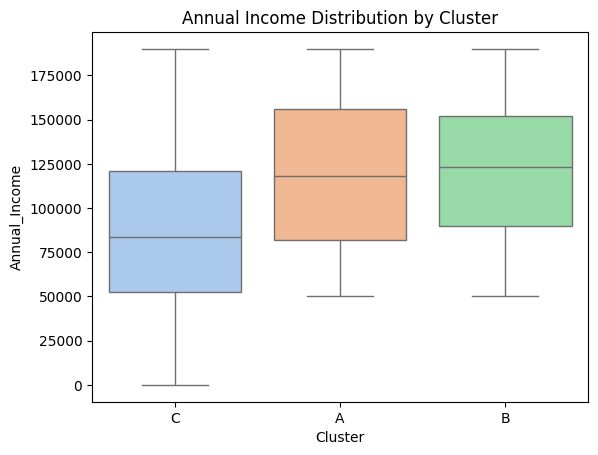

In [ ]:
# Annual_Income과 Cluster 관계 시각화
sns.boxplot(data=df, x='Cluster', y='Annual_Income', palette='pastel')
plt.title('Annual Income Distribution by Cluster')
plt.show()

# 결론

**[요약]**

- 성별: 여성은 1021명(59.2%), 남성은 705명(40.8%)이다
- 직업
    - Artist(32.7%)가 많은 비율을 차지하는 것으로 나타났는데 결측값을 최빈값으로 대체한 영향도 있을 것으로 추측된다
    - Artist(565명) 다음으로는 Healthcare(295명), Entertainment(201명), Engineer(163명)순으로 많고, Homemaker가 52명으로 제일 적다
- 연령: 전 연령대가 고르게 분포하며 그 중 30대가 제일 많고 70대가 제일 적다
- 연간 소득: 50000달러 이상에서 고르게 분포한다
- 소비 점수: 40 ~ 60점에 주로 분포하며 전체적으로 고르게 분포한다
- 근무 연수: 0 ~ 2.5년인 경우가 제일 많고 4 ~ 11년에서 고르게 분포한다
- 가족 수: 2명인 경우가 제일 많고 1 ~ 7명에서 고르게 분포한다

---

**[전략 제안]**

- 타겟 층
    - 성별: 여성
    - 직업군: Artist, Healthcare, Entertainment, Engineer
    - 연령: 30대
    - 소비 점수: 소비 점수가 중간인 경우가 많으므로 전체 고객의 소비 점수를 올릴 수 있는 방안 모색
    - 근무 연수: 근무 연수가 2.5년 이하
    - 가족 수: 가족 수가 2명 내외인 고객

---

**[고객 세분화 결과]**

- 최종 군집 개수는 **`3개`**이며 고객 그룹을 각 **`A, B, C`**로 나누었다.
- 비교적 세분화가 잘 된 그룹은 **`C`**이며, A와 B는 데이터 분포가 유사하다.
- 차이가 구분되는 컬럼은 **`Annual_Income`**으로 다른 변수들간의 차이가 확연히 구별된다.

---

**[데이터 세트의 한계]**

- 클러스터별 분포 확인을 보면 고객 그룹이 `CustomerID` 컬럼 기준으로 순서대로 나뉘어짐을 알 수 있다. 중간에 비어있는 번호는 삭제된 15세미만 데이터의 `CustomerID` 값으로 보인다.

|고객 그룹|최소||최대|
|--|--|--|--|
|A| 656| ~ |1328|
|B| 1329| ~ |2000|

- 그럼에도 `Annual_Income`값의 범위가 C그룹과 A, B그룹 간에 구별되는 이유는 데이터 세트가 실제 데이터를 기반으로 만들어진 것이 아닌 임의로 만들어진 데이터 세트이기 때문으로 보인다
- 데이터 세트의 볼륨이 작고 이상적인 구조인 경우 클러스터링이 비효율적일 수 있음을 의미한다
